- competition/dataset : [https://www.kaggle.com/c/data-science-bowl-2018](https://www.kaggle.com/c/data-science-bowl-2018)
- date : 2021/03/05
- original : [https://www.kaggle.com/kmader/nuclei-overview-to-submission](https://www.kaggle.com/kmader/nuclei-overview-to-submission)

## Nuclei Overview to Submission

**✏ 필사 1회** 

### Overview
1. 데이터 로드를 위한 전처리  
2. color-space의 간단한 시각화
3. 간단한 CNN 훈련
4. 테스트 데이터에 모델 적용
5. RLE 테스트 데이터 생성

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = 'data'
stage_label = 'stage1'

### Read in the Labels
트레이닝 셋의 RLE 인코딩된 결과 로드

In [2]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir, '{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
24186,cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9...,"[16582, 3, 16837, 5, 17093, 5, 17349, 5, 17605..."
21160,b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d4...,"[234436, 7, 234952, 13, 235470, 16, 235988, 19..."
18581,a0325cb7aa59e9c0a75e64ba26855d8032c46161aa4bca...,"[34305, 5, 34561, 6, 34817, 7, 35073, 8, 35329..."


### Load in all Images
이미지를 로드하고 경로를 처리하여 각 이미지에 적합한 정보(경로)를 할당합니다.

In [3]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path':all_images})
img_id = lambda in_path: in_path.split('\\')[-3]  # id
img_type = lambda in_path: in_path.split('\\')[-2]  # images or masks
img_group = lambda in_path: in_path.split('\\')[-4].split('_')[1]  # train or test
img_stage = lambda in_path: in_path.split('\\')[-4].split('_')[0]  # stage1
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(3)

,path,ImageId,ImageType,TrainingSplit,Stage
11526,data\stage1_train\5afcbfd0dd64392aa1e233b996d0...,5afcbfd0dd64392aa1e233b996d0bfb4354ee7119f30ae...,masks,train,stage1
3764,data\stage1_train\1c2f9e121fc207efff79d46390df...,1c2f9e121fc207efff79d46390df1a740566b683ff56a9...,masks,train,stage1
19519,data\stage1_train\a102535b0e88374bea4a1cfd9ee7...,a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a98...,masks,train,stage1


### Create Training Data
데이터프레임에 트레이닝 데이터를 만들고 모든 이미지를 로드했습니다. 여기서는 모든 영역을 구분하지 않고 함께 그룹화하여 단순화합니다.

In [4]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]

train_img_df = pd.DataFrame(train_rows)
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:, :, :IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

Wall time: 1min 58s


,Stage,ImageId,masks,images
217,stage1,50a7ea80dd73232a17f98b5c83f62ec89989e892fe25b7...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.0196078431372549, 0.0196078431372549, 0.0..."


In [5]:
train_img_df['masks'] = train_img_df['masks'].map(lambda x: x.astype('float32'))
train_img_df['images'] = train_img_df['images'].map(lambda x: x.astype('float32'))

### Show a few images
단일 분할 알고리즘 사용을 어렵게 만드는 밝은 영역과 형광의 혼합이 있는 셀 이미지 몇 개를 봅시다.

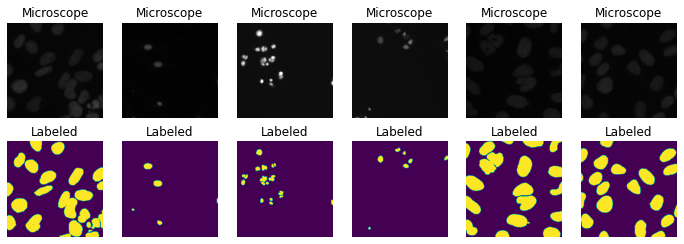

In [6]:
n_img = 6
fig, ax = plt.subplots(2, n_img, figsize=(12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), ax.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

### Look at the intensity distribution
이번에는 강도의 분포를 간단하기 살펴보며, 그룹이 형성되는 것을 볼 수 있습니다. 이 그룹들은 별도로 처리해야 할 필요가 있을 것입니다.

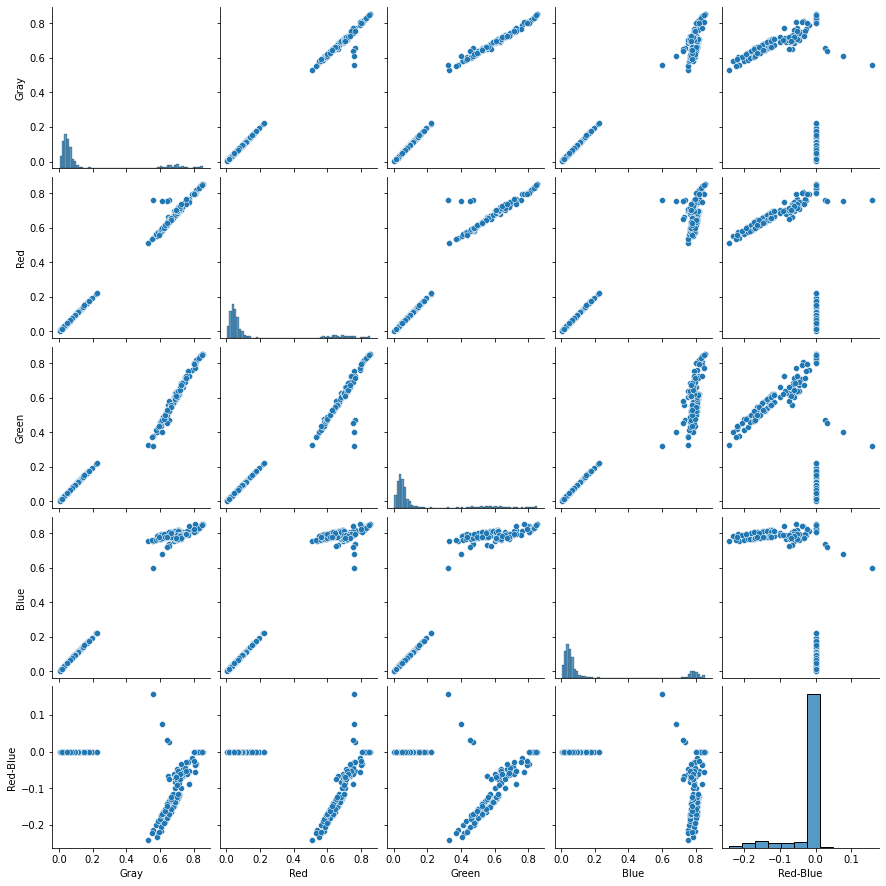

In [7]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Red-Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 0]-x[:, :, 2]))
sns.pairplot(train_img_df[['Gray', 'Red', 'Green', 'Blue', 'Red-Blue']])
plt.show()

### Check Dimensions
입력 이미지의 다양성을 보기 위해 데이터의 차원을 확인해보겠습니다.

In [8]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

### Making a simple CNN
CNN이 얼마나 잘 작동하는지 알 수 있도록 정말 간단한 CNN을 만듭니다. 입력값을 정규화하기 위해 batch normalization을 사용합니다. 문제를 간단하게 처리하기 위해 padding을 줍니다.

In [9]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape=(None, None, IMG_CHANNELS), name='NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size=(3, 3), padding='same'))
simple_cnn.add(Conv2D(8, kernel_size=(3, 3), padding='same'))
# 조금 더 넓은 시야를 확보하기 위해 확장
simple_cnn.add(Conv2D(16, kernel_size=(3, 3), dilation_rate=2, padding='same'))
simple_cnn.add(Conv2D(16, kernel_size=(3, 3), dilation_rate=2, padding='same'))
simple_cnn.add(Conv2D(32, kernel_size=(3, 3), dilation_rate=3, padding='same'))

# 최종 처리
simple_cnn.add(Conv2D(16, kernel_size=(1, 1), padding='same'))
simple_cnn.add(Conv2D(1, kernel_size=(1, 1), padding='same', activation='sigmoid'))
simple_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 8)     224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 16)    5

### Loss
결합에 대한 교차로 평가를 받기 때문에 DICE 점수의 역을 손실 함수로 사용하여 최적화할 수 있습니다.

In [10]:
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

simple_cnn.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef, 'acc', 'mse'])

### Simple Training
각 이미지에 자체 배치를 적용하는 간단한 훈련을 실행합니다.

In [15]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'], 0), np.expand_dims(np.expand_dims(c_row['masks'], -1), 0)
            
simple_cnn.fit_generator(simple_gen(), steps_per_epoch=train_img_df.shape[0], epochs=3)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
670/670 [==============================] - 232s 346ms/step - loss: -0.7311 - dice_coef: 0.7311 - acc: 0.8637 - mse: 0.1268
Epoch 2/3
670/670 [==============================] - 227s 338ms/step - loss: -0.7938 - dice_coef: 0.7938 - acc: 0.8914 - mse: 0.1012
Epoch 3/3
670/670 [==============================] - 244s 364ms/step - loss: -0.8039 - dice_coef: 0.8039 - acc: 0.8907 - mse: 0.1048


### Apply Model to Test

In [21]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType=="images"')['path'].values.tolist()
    test_rows += [c_row]

test_img_df = pd.DataFrame(test_rows)
test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:, :, :IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
Wall time: 793 ms


,Stage,ImageId,images
27,stage1,505bc0a3928d8aef5ce441c5a611fdd32e1e8eccdc15cc...,"[[[0.011764705882352941, 0.011764705882352941,..."


In [22]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

Wall time: 9.29 s


### Show a few predictions

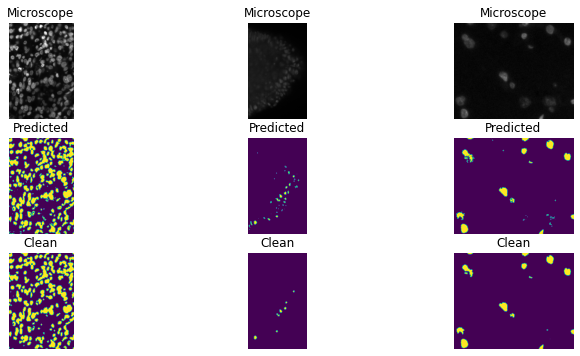

In [23]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, ax = plt.subplots(3, n_img, figsize=(12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), ax.T):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

### Check RLE

In [27]:
from skimage.morphology import label
def rle_encoding(x):
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off=0.5):
    lab_img = label(x > cut_off)
    if lab_img.max() < 1:
        lab_img[0, 0] = 1
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

### Calculate the RLEs for a Train Image

In [28]:
_, train_rle_row = next(train_img_df.tail(5).iterrows())
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

### Take the RLEs from the CSV

In [29]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']

### Check

In [31]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key=lambda x: x[0]),
                              sorted(tl_rles, key=lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1

print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%'%(match, mismatch, 100.0*match/(match + mismatch)))

Matches: 360, Mismatches: 0, Accuracy: 100.0%


### Calculate RLE for all the masks

In [65]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list += [
            dict(ImageId=c_row['ImageId'],
                 EncodedPixels = ' '.join(np.array(c_rle).astype(str)))
        ]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

1517 regions found for 65 images


,ImageId,EncodedPixels
119,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...,33230 3 33240 1 33747 7 33757 5 34266 16 34784...
434,43a71aeb641faa18742cb826772a8566c6c947d7050f9a...,62891 6 63149 10 63408 12 63667 14 63926 15 64...
675,697a05c6fe4a07c601d46da80885645ad574ea19b47ee7...,53313 2 53567 6 53823 7 54078 9 54333 11 54589...


In [74]:
out_pred_df.groupby('ImageId')['EncodedPixels'].min().to_frame().reset_index()

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,39077 1 39331 5 39585 7 39840 9 40096 9 40351 ...
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,10977 1 11494 5 12013 7 12531 8 13050 9 13568 ...
2,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,13313 1 13569 3 13825 5 14081 6 14337 6 14593 ...
3,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,20036 1 20290 6 20545 9 20801 10 21056 11 2131...
4,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,20736 1 20990 3 21246 3 21501 4 21758 3 22014 ...
...,...,...
60,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,103253 4 103770 9 104289 11 104807 13 105326 1...
61,f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002...,104517 4 105035 6 105553 8 106071 10 106590 11...
62,f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60a...,1 3636 3638 510 4151 494 4646 15 4662 494 5159...
63,fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...,15106 4 15361 7 15617 8 15873 8 16129 9 16385 ...


In [33]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('data/submission_3_predictions.csv', index = False)

In [75]:
# 최솟값
out_pred_df.groupby('ImageId')['EncodedPixels'].min().to_frame().reset_index().to_csv('data/submission_3_predictions_min.csv', index = False)